In [1]:
# import des librairies dont nous aurons besoin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st

# chargement et affichage des données

data = pd.read_csv('operations.csv')

display(data)

,date_operation,libelle,montant,solde_avt_ope,categ
0,2023-03-31,DON XX XX XX XX XX XX XX,-1.44,1515.25,AUTRE
1,2023-04-03,CARTE XX XX RAPT XX,-24.00,1513.81,TRANSPORT
2,2023-04-03,CARTE XX XX RAPT XX,-73.00,1489.81,TRANSPORT
3,2023-04-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,1416.81,AUTRE
4,2023-04-03,VIREMENT XX XX XX XX XX XX,4.80,2092.81,AUTRE
...,...,...,...,...,...
304,2023-10-05,CARTE XX XX XX XX XX XX,-10.64,2440.94,AUTRE
305,2023-10-05,CARTE XX XX XX XX,-4.80,2430.30,AUTRE
306,2023-10-06,FORFAIT COMPTE SUPERBANK XX XX XX XX,-1.92,2425.50,COTISATION BANCAIRE
307,2023-10-06,CARTE XX XX CHEZ LUC XX,-10.00,2423.58,RESTAURANT


In [2]:
data['date_operation'] = pd.to_datetime(data['date_operation'])
data_na = data.loc[data['montant'].isnull(),:]

# pour chaque ligne de mon df, on récupère les index (qui ne changent pas au travers du .loc)
for index in data_na.index:
    # calcul du montant à partir des soldes précédents et actuels
    data.loc[index, 'montant'] = data.loc[index+1, 'solde_avt_ope'] - data.loc[index, 'solde_avt_ope']
data.loc[data['categ'].isnull(), 'categ'] = 'FACTURE TELEPHONE'

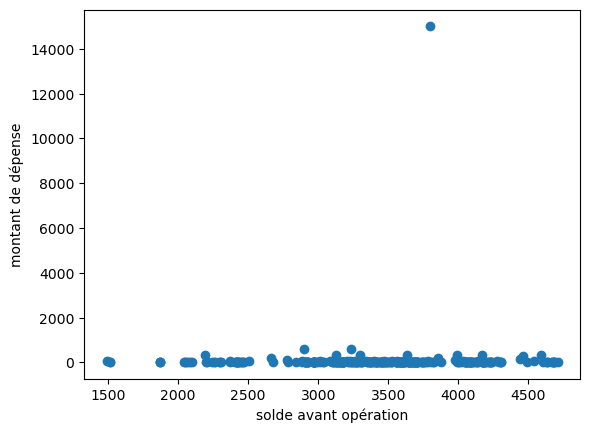

In [3]:
depenses = data[data.montant < 0]
plt.plot(depenses["solde_avt_ope"],-depenses["montant"],'o')
plt.xlabel("solde avant opération")
plt.ylabel("montant de dépense")
plt.show()

In [4]:
tranches = np.arange(0, data['solde_avt_ope'].max(), 500)
tranches += 250

In [5]:
indices = np.digitize(depenses["solde_avt_ope"], tranches) # associe chaque solde à son numéro de classe

In [6]:
len(depenses["solde_avt_ope"])

292

In [7]:
taille_classe = 500 # taille des classes pour la discrétisation

groupes = [] # va recevoir les données agrégées à afficher

for ind, tr in enumerate(tranches): # pour chaque tranche, ind reçoit le numéro de tranche et tr la tranche en question
    montants = -depenses.loc[indices==ind,"montant"]
    if len(montants) > 0:
        g = {
            'valeurs': montants,
            'centre_classe': tr-(taille_classe/2),
            'taille': len(montants),
            'quartiles': [np.percentile(montants,p) for p in [25,50,75]]
        }
        groupes.append(g)

In [8]:
print(groupes)

[{'valeurs': 0     1.44
1    24.00
2    73.00
Name: montant, dtype: float64, 'centre_classe': np.float64(1500.0), 'taille': 3, 'quartiles': [np.float64(12.72), np.float64(24.0), np.float64(48.5)]}, {'valeurs': 5       14.39
6       15.20
7       12.00
8        7.02
9        6.80
10       1.84
295     40.00
296      2.93
297     10.36
298    320.00
299      1.20
300      1.76
301     36.00
Name: montant, dtype: float64, 'centre_classe': np.float64(2000.0), 'taille': 13, 'quartiles': [np.float64(2.93), np.float64(10.36), np.float64(15.2)]}, {'valeurs': 169     12.48
170    190.80
171     13.60
172      6.49
173      4.80
174     20.80
175      9.20
176      4.80
177      9.60
178     32.00
179      4.88
180     60.16
290      8.52
291      7.12
292     23.33
293      9.31
294     12.00
303     67.68
304     10.64
305      4.80
306      1.92
307     10.00
308     13.58
Name: montant, dtype: float64, 'centre_classe': np.float64(2500.0), 'taille': 23, 'quartiles': [np.float64(6.805), np.flo

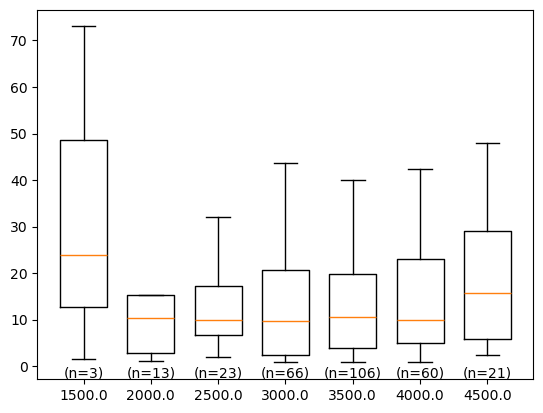

In [9]:
# affichage des boxplots
plt.boxplot([g["valeurs"] for g in groupes],
            positions= [g["centre_classe"] for g in groupes], # abscisses des boxplots
            showfliers= False, # on ne prend pas en compte les outliers
            widths= taille_classe*0.7) # largeur graphique des boxplots

# affichage des effectifs de chaque classe
for g in groupes:
    plt.text(g["centre_classe"],0,"(n={})".format(g["taille"]),horizontalalignment='center',verticalalignment='top')     
plt.show()

In [10]:
import scipy.stats as st

import numpy as np


print(st.pearsonr(depenses["solde_avt_ope"],-depenses["montant"])[0])

print(np.cov(depenses["solde_avt_ope"],-depenses["montant"],ddof=0)[1,0])

0.03433600219680249
19565.633633107762


In [11]:
# Selection du sous-échantillon
courses = data.loc[data.categ == "COURSES", :]

# On trie les opérations par date
courses = courses.sort_values("date_operation")

# On ramène les montants en positif
courses["montant"] = -courses["montant"]

# calcul de la variable attente
r = []
last_date = dt.datetime.now()
for i,row in courses.iterrows():
    days = (row["date_operation"]-last_date).days
    if days == 0:
        r.append(r[-1])
    else:
        r.append(days)
    last_date = row["date_operation"]
courses["attente"] = r
courses = courses.iloc[1:,]

# on regroupe les opérations qui ont été effectués à la même date
# (courses réalisées le même jour mais dans 2 magasins différents)
a = courses.groupby("date_operation")["montant"].sum()
b = courses.groupby("date_operation")["attente"].first()
courses = pd.DataFrame({"montant":a, "attente":b})

<Axes: xlabel='attente', ylabel='montant'>

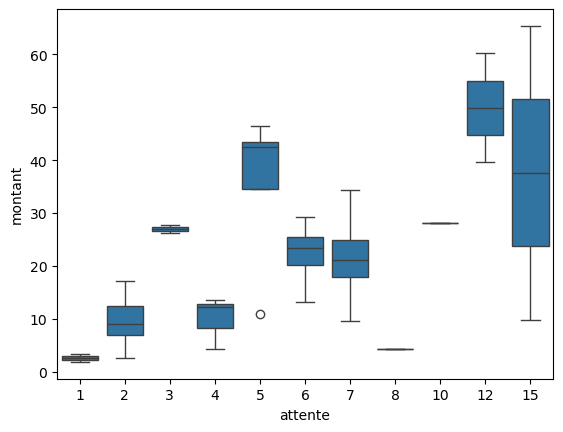

In [12]:
sns.boxplot(data=courses, x='attente', y='montant')

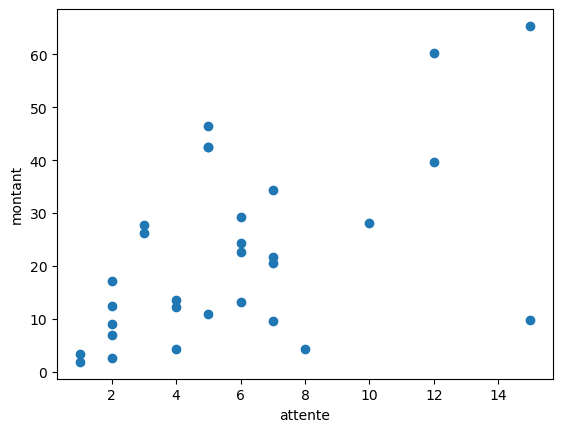

In [13]:
plt.plot(courses['attente'],courses['montant'], "o")
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

In [14]:
import statsmodels.api as sm

Y = courses['montant']
X = courses[['attente']]
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['attente'],result.params['intercept']

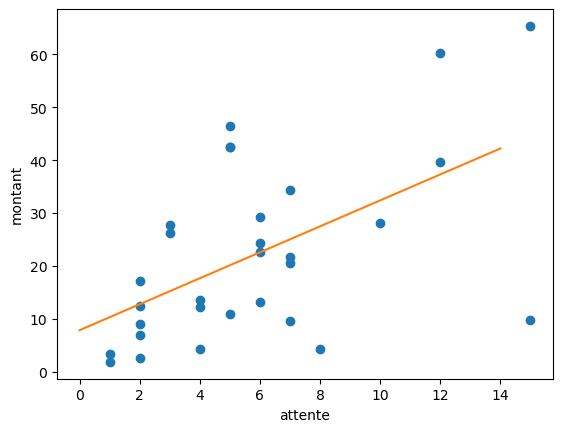

In [15]:
plt.plot(courses.attente,courses.montant, "o")
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()